In [1]:
# import os
# cpu_count = os.cpu_count()
# os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={cpu_count}'
# os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={1}'

In [2]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np

from src.hnmf_optimizer import HNMFOptimizer
from src.clusts import result_analysis
from green_model import reconstruct_general, gen_init_params,  gen_bounds, clustering_preprocess


# set true variables

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# # 5 sources
As = np.array([0.4, 0.3,0.2,0.5,0.7])
# positions of the source
Xs = np.array([
  [-0.25,0.45],
  [-0.08,0.2],
  [-0.15,0.25],
  [0.1,-0.1],
  [0.3,0.3]
])

# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

Xd = np.array([
[ -0.2,0.6],
[0,0.6],
[0.2,0.6],
[0.4,0.6],
[0.6,0.6],
[-0.2,0.4],
[0,0.4],
[0.2,0.4],
[0.4,0.4],
[0.6,0.4],
[-0.2,0.2],
[0,0.2],
[0.2,0.2],
[0.4,0.2],
[0.6,0.2],
[-0.2,0.0],
[0,0.0],
[0.2,0.0],
[0.4,0.0],
[0.6,0.0],
[-0.2,-0.2],
[0,-0.2],
[0.2,-0.2],
[0.4,-0.2],
[0.6,-0.2],
[-0.2,-0.4],
[0,-0.4],
[0.2,-0.4],
[0.4,-0.4],
[0.6,-0.4]
])

# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4


# NMF run

In [4]:
# generate observations from target variables with small noise

noise_level = 1e-4
observations = reconstruct_general(As, Xs, Ts, Xd, t, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise

I0000 00:00:1697844494.436061    3779 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
green_opt = HNMFOptimizer(
    model_fn = reconstruct_general,
    param_generator = gen_init_params,
    bound_generator = gen_bounds,
    input_args = ('t',),
    param_args = ('A_s', 'X_s', 'U', 'D'),
    constants = {'T_s': Ts, 'X_d': Xd},
    min_k = 1,
    max_k = 7,
    nsim = 100
)

res = green_opt(
    t,
    observations,
    opt_options = {
        'maxiter': 1500,
        'xtol': 1e-6,
        'fatol': 1e-10,
    }
)
Forclusts = clustering_preprocess(res)

Forclusts = Forclusts.groupby('num_sources', group_keys=False).apply(lambda group: result_analysis(
    group['points'].sum(),
    group['normF'].mean(),
    observations.size,
    group['num_sources'].iloc[0]
))

SIMULATIONS FOR 1 SOURCES TOOK 13.185152769088745 SECONDS
SIMULATIONS FOR 2 SOURCES TOOK 8.560484647750854 SECONDS
SIMULATIONS FOR 3 SOURCES TOOK 10.564750909805298 SECONDS
SIMULATIONS FOR 4 SOURCES TOOK 13.28142523765564 SECONDS
SIMULATIONS FOR 5 SOURCES TOOK 118.2323362827301 SECONDS
SIMULATIONS FOR 6 SOURCES TOOK 104.30181097984314 SECONDS
SIMULATIONS FOR 7 SOURCES TOOK 74.45330452919006 SECONDS
Clustering  2
Clustering  3
Clustering  4
Clustering  5
Clustering  6
Clustering  7


In [6]:
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-1.323363e+04,1.000000,1.000000,9.663721,"[1.4999968128831227, 0.016963587699956678, 0.2..."
0,2,-1.573192e+04,1.000000,1.000000,3.409580,"[[1.2536621710673659, 0.7656066711634112], [-0..."
0,3,-1.802935e+04,1.000000,1.000000,1.307993,"[[0.5184946619812346, 0.46163994422173354, 0.9..."
0,4,-2.838573e+04,1.000000,1.000000,0.017466,"[[0.7036228299013093, 0.5046672852409937, 0.41..."
0,5,-3.282014e+04,0.998179,0.991134,0.002750,"[[0.19735396681678208, 0.7000365667239944, 0.4..."
0,6,inf,0.433554,-0.622740,0.002748,"[[0.30424036920005454, 0.39518085945019243, 0...."
0,7,inf,0.340099,-0.392761,0.002827,"[[0.296954230562555, 0.5892364383980848, 0.423..."


In [7]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all, output_dir):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(output_dir+"Selection_plot.png")
    plt.show()

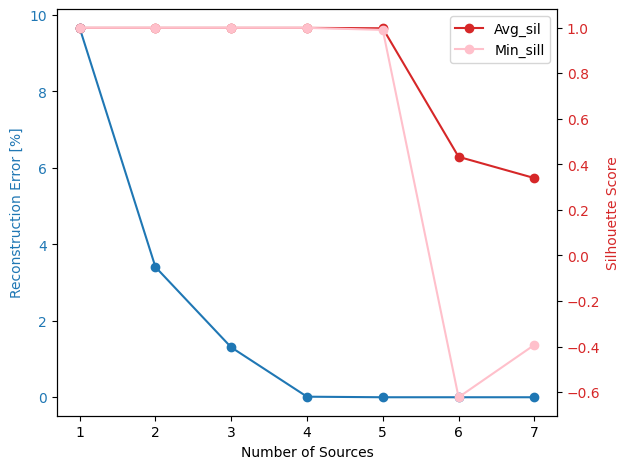

In [8]:
OUTPUTDIR = "Results/"
os.makedirs(OUTPUTDIR,exist_ok=True)

numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all,OUTPUTDIR)

In [9]:
Forclusts['centers'].iloc[4]

array([[ 0.19735397,  0.70003657,  0.49999679,  0.39986802,  0.30271672],
       [-0.15052507,  0.29996125,  0.10000706, -0.25001308, -0.08037543],
       [ 0.25052655,  0.29999648, -0.10000335,  0.45002224,  0.20015592],
       [ 0.05000001,  0.05000001,  0.05000001,  0.05000001,  0.05000001],
       [ 0.00499997,  0.00499997,  0.00499997,  0.00499997,  0.00499997],
       [ 0.00125   ,  0.00125   ,  0.00125   ,  0.00125   ,  0.00125   ]])

In [10]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.4 ,  0.3 ,  0.2 ,  0.5 ,  0.7 ],
       [-0.25, -0.08, -0.15,  0.1 ,  0.3 ],
       [ 0.45,  0.2 ,  0.25, -0.1 ,  0.3 ]])